![title](https://i.stack.imgur.com/7qDiV.png)

In the previous notebook we saw linear regression, a way to fit a straight line through data, in order to fit a model for unknown data points. Now imagine that you have data points, that instead of being continous variables like in the previous notebook, we have two labels. Let's this example in which we have test scores for two tests, and a label which tells us if the student got admitted or not.

In [1]:
import pandas as pd
import numpy as np

data1 = pd.read_csv("LogR.csv",header = None)
data1.head()

,0,1,2
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


Let's add some labels to the columns. 

In [2]:
data1.columns = ["Test1","Test2","Admitted"]
data1.head()

,Test1,Test2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In this data, admitted students are marked with a 1 on the admitted on column, and students that are not admitted are marked with a 0. This is common on classification problems which have only two labels. These are called **binary classification** problems. The goal here is to predict, based on the two test scores, if the student got admitted or not. Let's draw a plot to view how the admitted and not admitted students differ.

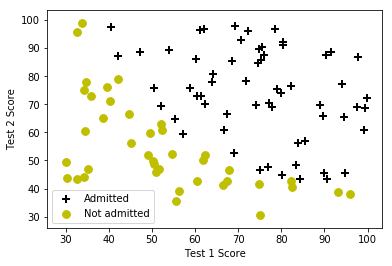

In [3]:
import matplotlib.pyplot as plt
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # Get indexes for class 0 and class 1
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    
    # If no specific axes object has been passed, get the current axes.
    if axes == None:
        axes = plt.gca()
    #Create a scatter plot for test data for admitted and not admitted students.
    axes.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    #Set the legend for the plot.
    axes.legend(frameon= True, fancybox = True)
    
plotData(data1.values,"Test 1 Score","Test 2 Score","Admitted","Not admitted")
plt.show()

In this problem,  we can see that most  positive labels are on one side, and most negative labels are on another side. The objetive of **Logistic Regression** is to fit a line that serves as a threshold to separate the positive and negative labels. Thus, new data points will be classified based on if their position is over or under this line. Let's try plotting an example line to see how it would look.

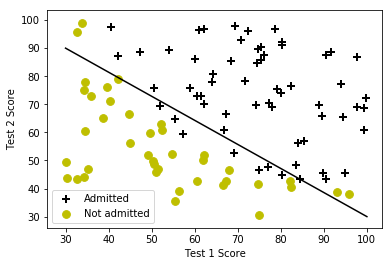

In [4]:
plotData(data1.values,"Test 1 Score","Test 2 Score","Admitted","Not admitted")
plt.plot([30, 100], [90, 30], 'k-')
plt.show()

In this example, exam scores that are over the line are considered positive, and those under  the line are considered negative. There are some misclassifications here and there, but the goal of Logistic Regression is to optimize this line to get the maximum accuracy. Aside from that, Logistic Regression is very similar to Linear Regression, with its Hypothesis function, Cost function and Gradient. Let's first see the Hypothesis function, which in this case is the **sigmoid function**. A sigmoid function is a function having the characteristics of an "S", which goes from 0 to 1 in the y-axis. If we try plotting the average score for the exams, and if the student got admitted or not, we would get a plot in which the data points are only on 0 or 1. Let's see this in action:

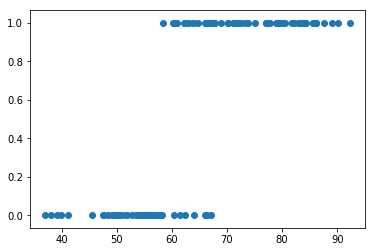

In [5]:
mean_score = ((data1.Test1 + data1.Test2)/2)
plt.scatter(mean_score,data1.Admitted)
plt.show()


The sigmoid function would draw a line with an "S" shape between these two data points, and separate them. The formula for the sigmoid function is this: 

$S(x)  = \dfrac{1}{1 + e^{-x}} $

This function always returns a value between 0 and 1, which means that if we set a certain threshold like 0.5, values that the function returns that are below 0.5 are negative, and those over 0.5 are positive. Let's define the function programmatically:

In [6]:
def sigmoid_function(x):
    #Computes the sigmoid function.
    sigmoid = 1/(1 + np.exp(-x) + 1e-8)
    return sigmoid


The point of the $1 \cdot 10^{-8}$ is to prevent division by zero, by adding a very small number so that it doesn't affect the calculations. This is also called epsilon or $\epsilon$. Let's now use the activation function to plot the sigmoid curve for the test scores.

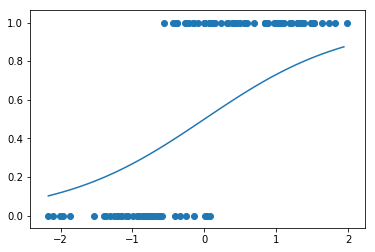

In [7]:
# Use mean normalization to normalize the average test scores per student.
st_mean_score = (mean_score - mean_score.mean())/mean_score.std()
#Calculate minimum , maximum and the range of the normalized scores.
min = st_mean_score.min()
max = st_mean_score.max()
nrange = (max - min)/(len(st_mean_score))

# Create a list of numbers within the range.
x = np.arange(min,max, nrange)
#Calculate the sigmoid activation for each number.
sig = sigmoid_function(x)
#Plot the curve.
plt.plot(x,sig)
plt.scatter(st_mean_score,data1.Admitted)
plt.show()

While not exactly "S" like since there's overlapping between the two labels, the sigmoid function separates certain labels from others based on their scores. The result of the sigmoid function is the *probability* that the positive result is true. For example, if the sigmoid function outputs a 0.9, it means that for those test scores there's a 90% probability that the student will be admitted. Now that we are done with the hypothesis function, let's proceed with the **Cost Function**. As we explained before in linear regression, the cost function is the errors of our hypothesis function. In the case of Logistic Regression and binary classification, since the labels can only be 0 or 1, the error would be how far away the result of the logistic function was from 0 if y = 0 or how far away the result of the logistic function was from 1, if y = 1.  Since we need the opposite of the sigmoid function would be the log of the number, the calculation of the cost would be:

![title](https://i.stack.imgur.com/9C6w5.png)

The final equation is  $Err(h_\theta(x), y)  = \dfrac{1}{m}(-(1 - y^T)log(1 - h_\theta(x))) \cdot y^Tlog(h_\theta(x))$ (since we are using vectors). When y = 1, the first term of the equation is equal to 0, because of y - 1, thus leaving only the second part of the equation. This part is the same as the condition of the equation of y = 1. The same is also true for when y = 0. Thus we can simplify the cost function into only one equation. Let's create a function that performs this calculation.


In [8]:
def Cost_Function(X,y, theta):
        #Hyposthesis or sigmoid
        hyp = sigmoid_function(X.dot(theta))
        #Formula for the cost.
        size = 1/y.size
        
        #Vectorized cost function
        p = np.log(hyp).T.dot(y) #Case y = 1
        invp = np.log(1-hyp).T.dot(1-y) #Case y = 0
        
        cost = -1* size * (p + invp) 
        return cost


Let's test the cost function with a theta vector of 0s.

In [10]:
#Include x0 just like in linear regression.

data1["x0"] = 1
data1 = data1[["x0","Test1","Test2","Admitted"]]

#Create the X matrix and leave out the label column
X = data1[[column for column in data1.columns if  column is not "Admitted"]].values


#Test the Cost_Function with a theta of 0.
print(Cost_Function(X,data1.Admitted,np.zeros(X.shape[1])))

0.69314718156


So we still have  a ways to go. Just like in linear regression, let's now move on to **Gradient Descent**. In this case, it's exactly the same as in linear regression, just with a different hypothesis function.

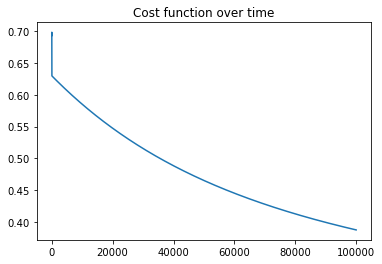

Best theta was: [-4.8118003   0.04528064  0.0381915 ]


In [13]:
def Gradient_Descent(X,y,epochs,theta,lrate = 0.001):
    size = y.size
    cost_history = []
    for i in range(epochs):
        hyp = sigmoid_function(X.dot(theta))
        cost = Cost_Function(X,y,theta)
        cost_history.append(cost)
        gradient = (1/size) * X.T.dot(hyp - y)
        theta = theta - lrate * gradient
    
    plt.plot(range(0,epochs),cost_history)
    plt.title("Cost function over time")
    plt.show()
    return theta

initial_theta = np.zeros(X.shape[1])
print("Best theta was: " + str(Gradient_Descent(X,data1.Admitted,100000,initial_theta)))

In this problem, it's taking a lot to learn, so I increased the number of training epochs in a substantial amount. Since we have all we need, let's create the function that predicts unknown values.

In [14]:
def predict(theta, X, threshold=0.5):
        p = sigmoid_function(X.dot(theta.T)) >= threshold
        return(p.astype('int'))


And finally, let's gauge the accuracy of prediction of the model. We'll train for the best theta from gradient descent, using 500000 training epochs. This is not advisable in practice, since in our example we only have 91 training examples, and real data may have millions of rows. The best course of action would be to find a learning rate that learns more quickly, to train it for a lower number of training epochs. 

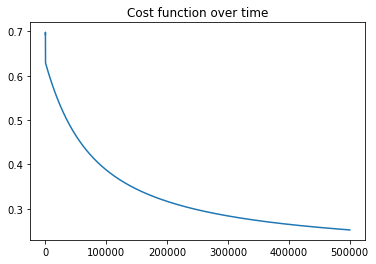

Training accuracy was 91.0%


In [15]:
best_theta = Gradient_Descent(X,data1.Admitted,500000,initial_theta)
predictions = predict(best_theta,X)
correct_ratio = sum(predictions == data1.Admitted.ravel())/predictions.size #The ratio of correct predictions 
print('Training accuracy was ' + str(correct_ratio*100) + '%' )

And finally, let's plot the decision boundary. This is the line that separates positive labels from negative ones.

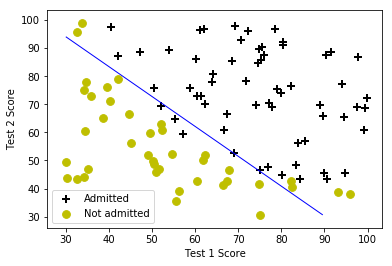

In [16]:

#Create max and min values for both test scores.
x1_min, x1_max = X[:,1].min(), X[:,1].max(),
x2_min, x2_max = X[:,2].min(), X[:,2].max(),


#Create a 2D grid for each test score.
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
xx0 =np.ones((xx1.ravel().shape[0],1)) #X0 filled with 1s.

#Create a vector with the predictions from the sigmoid function, for each test score, with the best theta.
h = sigmoid_function(np.c_[xx0, xx1.ravel(), xx2.ravel()].dot(best_theta)) 
h = h.reshape(xx1.shape)

#Plot the line separating the two sections.
plotData(data1.drop("x0",axis = 1).values,"Test 1 Score","Test 2 Score","Admitted","Not admitted")
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b');
plt.show()

And there we go. The model has a 91% accuracy. 

To do the same but with scikit-learn, we would just do the following:

In [17]:
from sklearn.linear_model import LogisticRegression

biclassifier = LogisticRegression()
biclassifier.fit(X[:,1:],data1.Admitted)
skpredictions = biclassifier.predict(X[:,1:])
skcorrect_ratio = sum(skpredictions == data1.Admitted.ravel())/skpredictions.size
print(skcorrect_ratio)

0.87


## Non-Linear Regression

Now imagine this situation, where you have two microchip voltage values. 

In [18]:
data2 = pd.read_csv("LogR2.csv",header = None)
data2.columns = ["Microchip1","Microchip2","Pass"]
data2.head()

,Microchip1,Microchip2,Pass
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


Let's plot how they look in a grid, just like before.

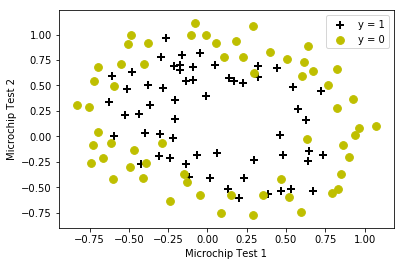

In [19]:
plotData(data2.values, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')
plt.show()

In this case the relationship between the variables is way more complicated, and there's no way a line as a decision function would be able to separate the data well. However, there's more ways than a line to represent a function. Let's for example visualize the $x^2$ function. You can change this code to see other nonlinear functions.

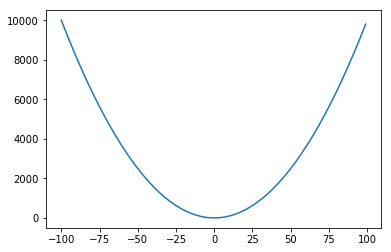

In [20]:
n = 2
x = range(-100,100,1)
y = [i**n for i in x]

plt.plot(x,y)
plt.show()

Remember that at the end of the day, we are looking for a function that fits our data well. So using polynomial features, features with a exponent greater than 1, may yield much better results for the data. scikit-learn comes with an easy way to implement polynomial features, so we'll use just that.

In [21]:
from sklearn.preprocessing import PolynomialFeatures

XX = data2.values[:,0:2]
#Create a 6 degree polynomial for the features.
poly = PolynomialFeatures(6)
polyXX = poly.fit_transform(XX)
polyXX.shape

(118, 28)

Now we have 28 features, instead of 2. This is because we added the polynomial features of the variables beginning with the 6th degree, like $x^6$,$5x^5$ and so on. Let's now train the model with these extra polynomial features.

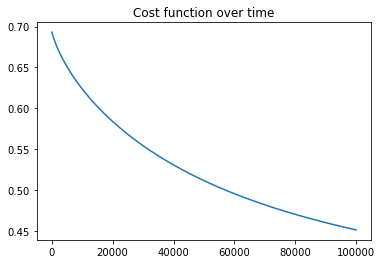

Training accuracy was 83.0508474576%


In [22]:
initial_thetapoly = np.zeros(polyXX.shape[1])
best_thetapoly = Gradient_Descent(polyXX,data2.Pass,100000,initial_thetapoly)
polypredictions = predict(best_thetapoly,polyXX)
polycorrect_ratio = sum(polypredictions == data2.Pass.ravel())/polypredictions.size #The ratio of correct predictions 
print('Training accuracy was ' + str(polycorrect_ratio*100) + '%' )

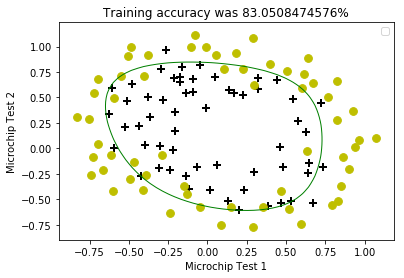

In [77]:
plotData(data2.values, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')
    
    # Plot decisionboundary
x1_min, x1_max = XX[:,0].min(), XX[:,0].max(),
x2_min, x2_max = XX[:,1].min(), XX[:,1].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = sigmoid_function(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(best_thetapoly))
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='g');       
plt.title('Training accuracy was ' + str(polycorrect_ratio*100) + '%' )
plt.legend('')
plt.show()

While not a terrible good accuracy, it still gets the job done, and generalizes well. 